# LocalDensity
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles.
In this notebook, we demonstrate `freud`'s local density calculation, which can be used to characterize the particle distributions in some systems. 
In this example, we consider a toy example of calculating the particle density in the vicinity of a set of other points.
This can be visualized as, for example, billiard balls on a table with certain regions of the table being stickier than others.
In practice, this method could be used for analyzing, *e.g*, binary systems to determine how densely one species packs close to the surface of the other.

In [1]:
import numpy as np
import freud
import util
import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
# Define some helper plotting functions.
def add_patches(ax, points, radius=1, fill=False, color="#1f77b4", ls="solid", lw=None):
    """Add set of points as patches with radius to the provided axis"""
    for pt in points:
        p = patches.Circle(pt, fill=fill, linestyle=ls, radius=radius,
                           facecolor=color, edgecolor=color, lw=lw)
        ax.add_patch(p)

def plot_lattice(box, points, radius=1, ls="solid", lw=None):
    """Helper function for plotting points on a lattice."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    box_points = util.box_2d_to_points(box)
    ax.plot(box_points[:, 0], box_points[:, 1], color='k')
    
    add_patches(ax, points, radius, ls=ls, lw=lw)
    return fig, ax

Let us consider a set of regions on a square lattice.

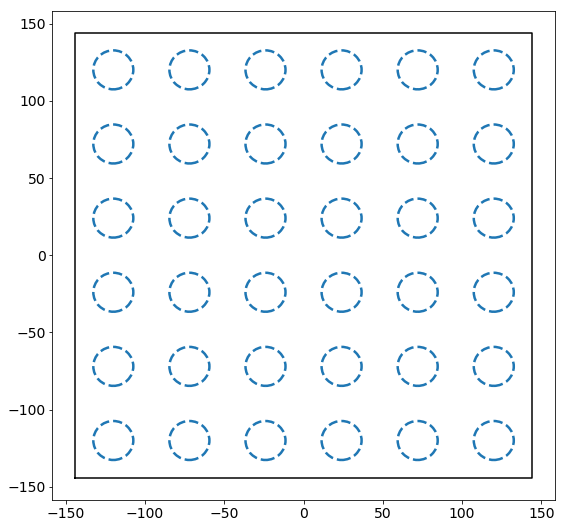

In [3]:
area = 5
radius = np.sqrt(area/np.pi)
ref_area = area*100
ref_radius = np.sqrt(ref_area/np.pi)
num = 6
scale = num*4
box, ref_points = util.make_square(num, num, scale=scale)
ref_points[..., [0, 1]] += scale
fig, ax = plot_lattice(box, ref_points, ref_radius, ls="dashed", lw=2.5)
plt.tick_params(axis="both", which="both", labelsize=14)
plt.show()

Now let's add a set of points to this box.
Points are added by drawing from a normal distribution centered at each of the regions above.
For demonstration, we will assume that each region has some relative "attractiveness", which is represented by the covariance in the normal distributions used to draw points.
Specifically, as we go up and to the right, the covariance increases proportional to the distance from the lower right corner of the box.

In [4]:
points = []
distances = np.linalg.norm(ref_points + np.array(box.L)/2, axis=-1)
cov_basis = 20*distances/np.min(distances)
for i, p in enumerate(ref_points):
    cov = cov_basis[i]*np.eye(3)
    cov[2, 2] = 0  # Nothing in z
    points.append(
        np.random.multivariate_normal(p, cov, size=(50,)))
points = box.wrap(np.concatenate(points))

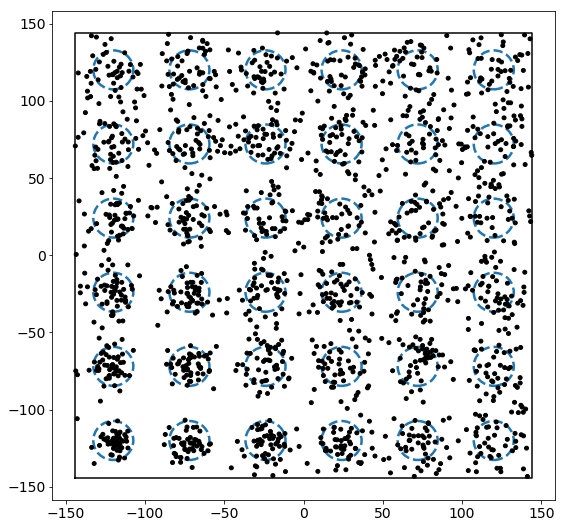

In [5]:
fig, ax = plot_lattice(box, ref_points, ref_radius, ls="dashed", lw=2.5)
plt.tick_params(axis="both", which="both", labelsize=14)
add_patches(ax, points, radius, True, 'k', lw=None)
plt.show()

We see that the density increases as we move up and to the right.
In order to compute the actual densities, we can leverage the LocalDensity class.
The class allows you to specify a set of reference points around which the number of other points is computed.
These other points can, but need not be, distinct from the reference points.
In our case, we want to use the regions as our reference points with the small circles as our data points.

When we construct the LocalDensity class, there are three arguments.
The first is the radius from the reference points within which particles should be included in the reference point's counter.
The second and third are the volume and the circumsphere diameters of the **data points**, not the reference points.
This distinction is critical for getting appropriate density values, since these values are used to actually check cutoffs and calculate the density.

In [6]:
density = freud.density.LocalDensity(ref_radius, area, radius)
num_neighbors = density.compute(box, ref_points, points).num_neighbors
densities = density.compute(box, ref_points, points).density

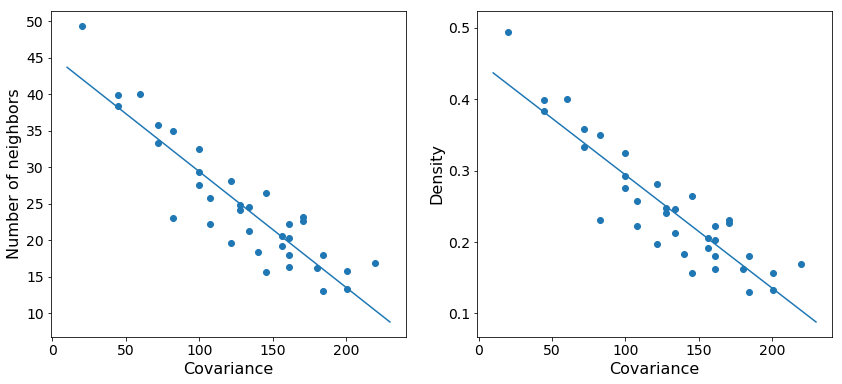

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, data in enumerate([num_neighbors, densities]):
    poly = np.poly1d(np.polyfit(cov_basis, data, 1))
    axes[i].tick_params(axis="both", which="both", labelsize=14)
    axes[i].scatter(cov_basis, data)
    x = np.linspace(*axes[i].get_xlim(), 30)
    axes[i].plot(x, poly(x), label="Best fit");
    axes[i].set_xlabel("Covariance", fontsize=16)
    
axes[0].set_ylabel("Number of neighbors", fontsize=16);
axes[1].set_ylabel("Density", fontsize=16);
plt.show()

As expected, we see that increasing the variance in the number of points centered at a particular reference point decreases the total density at that point.
The trend is noisy since we are randomly sampling possible positions, but the general behavior is clear.